#**Implemented By Muhammad Hanan Asghar**

In [ ]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content"# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
# !kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

In [ ]:
#unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zip

In [1]:
from google.colab import drive
drive.mount('/drive')
%cd /drive

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive


In [2]:
# !cp -v -r '/content/Face Mask Dataset/' /drive/MyDrive

In [3]:
import os

BASE_DIR = "/drive/MyDrive/Face Mask Dataset"
DIRS = os.listdir(BASE_DIR)
TRAIN_DIR = os.path.join(BASE_DIR, DIRS[1])
TEST_DIR = os.path.join(BASE_DIR, DIRS[0])

In [4]:
print(TRAIN_DIR, " ---- ", TEST_DIR)

/drive/MyDrive/Face Mask Dataset/Train  ----  /drive/MyDrive/Face Mask Dataset/Test


In [5]:
os.listdir(TRAIN_DIR)

['WithMask', 'WithoutMask']

In [19]:
import cv2
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


#**Train Data Preprocessing**

In [7]:
!nvidia-smi

Mon Dec 28 10:18:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

WithMask = 1
WithoutMask = 0

In [8]:
img_rows, img_columns = 112, 112

images = []
labels = []

In [ ]:
id = 0
for directory in os.listdir(TRAIN_DIR):
  ROOT_OF_DIR = os.path.join(TRAIN_DIR, directory)
  for pack in os.listdir(os.path.join(TRAIN_DIR,directory))[:1000]:
    try:
      id += 1
      print(id)
      image = os.path.join(ROOT_OF_DIR, pack)
      print(pack)
      image = cv2.imread(image)
      gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      resized = cv2.resize(gray_scale, (img_rows, img_columns))
      images.append(resized)
      labels.append(directory)
    except:
      pass

#**Test Data Preprocessing**

In [ ]:
id = 0
for directory in os.listdir(TEST_DIR):
  ROOT_OF_DIR = os.path.join(TEST_DIR, directory)
  for pack in os.listdir(os.path.join(TEST_DIR,directory)):
    try:
      id += 1
      print(id)
      image = os.path.join(ROOT_OF_DIR, pack)
      image = cv2.imread(image)
      gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      resized = cv2.resize(gray_scale, (img_rows, img_columns))
      images.append(resized)
      labels.append(directory)
    except:
      pass

In [11]:
images = np.array(images) / 255.0
images = np.reshape(images, (images.shape[0], 112, 112, 1))

In [51]:
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)
labels = np.array(labels)

In [52]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [53]:
print("Length of Independent Elements:", len(images))
print("Length of Dependent Elements:", len(labels))

Length of Independent Elements: 2992
Length of Dependent Elements: 2992


In [54]:
import matplotlib.pyplot as plt


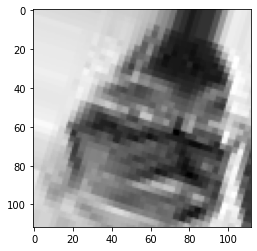

In [55]:
plt.imshow(images[0].reshape(112, 112), cmap="binary")

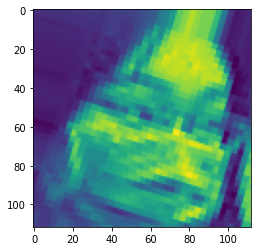

In [56]:
plt.imshow(images[0].reshape(112, 112))

In [57]:
train_X, test_X, train_y, test_y = train_test_split(images, labels, test_size=0.15, random_state=0)

**Build CNN**

In [58]:
!pip install -q keras-tuner

In [59]:
import keras
import os
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.layers import Dense, Dropout
from kerastuner import RandomSearch

In [60]:
def Model(hp):
  cnn = Sequential()
  cnn.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
                 kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                 input_shape=(112, 112, 1), 
                 activation='relu')) 
  
  cnn.add(MaxPooling2D(pool_size=(2, 2)))
   
  cnn.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=16),
                 kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                 activation='relu'))
  
  cnn.add(MaxPooling2D(pool_size=(2, 2)))
  
  cnn.add(Flatten())

  cnn.add(Dense(units=hp.Int('dense_1_units', 
                min_value=512, max_value=1024, step=16),
                activation='relu'))
  cnn.add(Dropout(rate=0.5))

  cnn.add(Dense(units=2, activation='softmax'))

  cnn.compile(optimizer=keras.optimizers.RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return cnn

In [61]:
train_X.shape

(2543, 112, 112, 1)

In [62]:
train_y.shape

(2543, 2)

In [63]:
!rm -rf /content/outputs

In [64]:
tuner = RandomSearch(Model,
                    objective='val_accuracy',
                    max_trials=5,
                    directory='/content/outputs',
                    project_name="Mask Detection")

In [65]:
tuner.search(train_X, train_y, epochs=10, validation_split=0.1)

Trial 5 Complete [00h 00m 38s]
val_accuracy: 0.5490196347236633

Best val_accuracy So Far: 0.9764705896377563
Total elapsed time: 00h 03m 44s
INFO:tensorflow:Oracle triggered exit


In [66]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 108, 108, 112)     2912      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 112)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 52, 52, 128)       129152    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0         
_________________________________________________________________
dense (Dense)                (None, 800)               69223200  
_________________________________________________________________
dropout (Dropout)            (None, 800)               0

In [73]:
history = model.fit(train_X,train_y,
          epochs=10,
          initial_epoch=3, validation_split=0.1)

Epoch 4/10
72/72 [==============================] - 4s 59ms/step - loss: 0.1195 - accuracy: 0.9808 - val_loss: 0.4144 - val_accuracy: 0.8980
Epoch 5/10
72/72 [==============================] - 4s 58ms/step - loss: 0.0523 - accuracy: 0.9873 - val_loss: 0.1748 - val_accuracy: 0.9569
Epoch 6/10
72/72 [==============================] - 4s 59ms/step - loss: 0.1520 - accuracy: 0.9812 - val_loss: 0.2254 - val_accuracy: 0.9647
Epoch 7/10
72/72 [==============================] - 4s 58ms/step - loss: 0.0537 - accuracy: 0.9882 - val_loss: 0.1884 - val_accuracy: 0.9686
Epoch 8/10
72/72 [==============================] - 4s 58ms/step - loss: 0.4240 - accuracy: 0.9764 - val_loss: 0.8109 - val_accuracy: 0.8980
Epoch 9/10
72/72 [==============================] - 4s 59ms/step - loss: 0.1240 - accuracy: 0.9869 - val_loss: 0.2590 - val_accuracy: 0.9686
Epoch 10/10
72/72 [==============================] - 4s 58ms/step - loss: 0.2128 - accuracy: 0.9830 - val_loss: 0.2689 - val_accuracy: 0.9647


#**Plotting Train Loss And Accuracy**

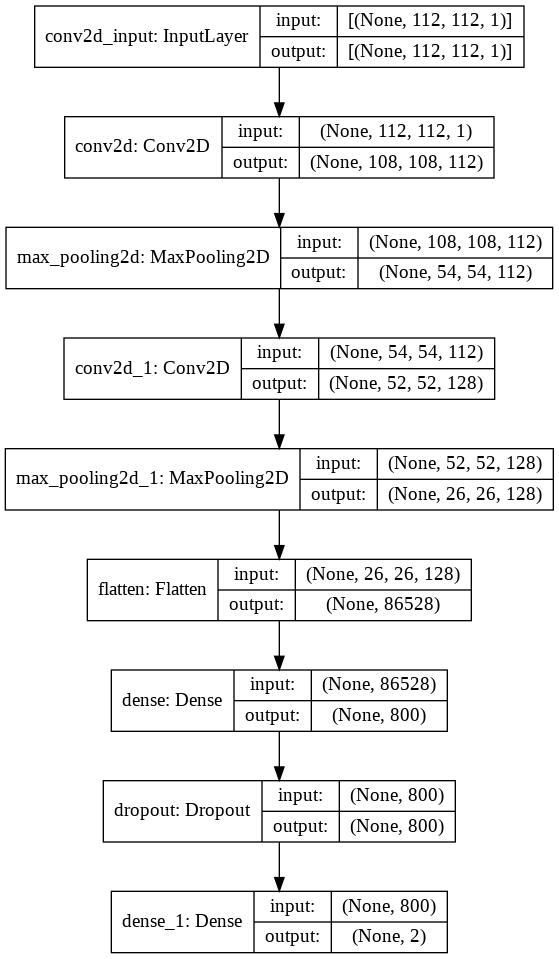

In [81]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='/drive/MyDrive/model_plot.png', show_shapes=True, show_layer_names=True)

In [75]:
loss, accuracy = model.evaluate(test_X, test_y)
print("The Accuarcy of My Model is:", accuracy)
print("The Loss of My Model is:", loss)

15/15 [==============================] - 0s 15ms/step - loss: 0.4164 - accuracy: 0.9532
The Accuarcy of My Model is: 0.9532294273376465
The Loss of My Model is: 0.4164045751094818


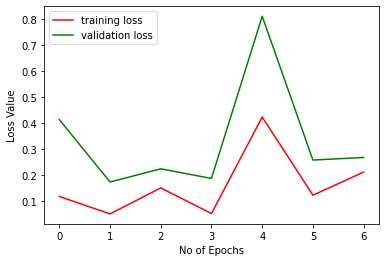

In [78]:
plt.plot(history.history['loss'], 'r', label='training loss')
plt.plot(history.history['val_loss'], 'g', label='validation loss')
plt.xlabel("No of Epochs")
plt.ylabel('Loss Value')
plt.legend()
plt.show()

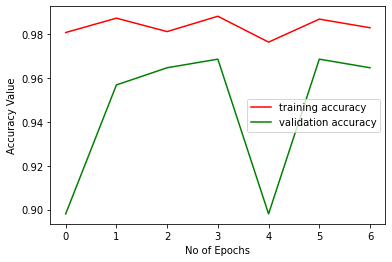

In [79]:
plt.plot(history.history['accuracy'], 'r', label='training accuracy')
plt.plot(history.history['val_accuracy'], 'g', label='validation accuracy')
plt.xlabel("No of Epochs")
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

In [80]:
model.save("/drive/MyDrive/model_mask_detection.h5")

In [82]:
# /drive/MyDrive/Face Mask Dataset/Validation/WithoutMask/1189.png
# /drive/MyDrive/Face Mask Dataset/Validation/WithoutMask/1002.png
# /drive/MyDrive/Face Mask Dataset/Validation/WithoutMask/1003.png

In [88]:
cnn = keras.models.load_model("/drive/MyDrive/model_mask_detection.h5")

In [92]:
test_image = cv2.imread("/drive/MyDrive/Face Mask Dataset/Validation/WithoutMask/1189.png")
test_image_grayscale = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image_resize = cv2.resize(test_image_grayscale, (112, 112))
normalized_image = test_image_resize / 255.0
result_image = np.reshape(test_image_resize, (1, 112, 112, 1))
result_image.shape
result = cnn.predict(result_image)
if int(result[0][0]) == 1:
  print("With Mask")
elif int(result[0][1]) == 1:
  print("Without Mask")

Without Mask


In [93]:
test_image = cv2.imread("/drive/MyDrive/Face Mask Dataset/Validation/WithoutMask/1002.png")
test_image_grayscale = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image_resize = cv2.resize(test_image_grayscale, (112, 112))
normalized_image = test_image_resize / 255.0
result_image = np.reshape(test_image_resize, (1, 112, 112, 1))
result_image.shape
result = cnn.predict(result_image)
if int(result[0][0]) == 1:
  print("With Mask")
elif int(result[0][1]) == 1:
  print("Without Mask")

Without Mask


In [94]:
test_image = cv2.imread("/drive/MyDrive/Face Mask Dataset/Validation/WithoutMask/1003.png")
test_image_grayscale = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image_resize = cv2.resize(test_image_grayscale, (112, 112))
normalized_image = test_image_resize / 255.0
result_image = np.reshape(test_image_resize, (1, 112, 112, 1))
result_image.shape
result = cnn.predict(result_image)
if int(result[0][0]) == 1:
  print("With Mask")
elif int(result[0][1]) == 1:
  print("Without Mask")

Without Mask


In [96]:
test_image = cv2.imread("/drive/MyDrive/Face Mask Dataset/Validation/WithMask/1204.png")
test_image_grayscale = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image_resize = cv2.resize(test_image_grayscale, (112, 112))
normalized_image = test_image_resize / 255.0
result_image = np.reshape(test_image_resize, (1, 112, 112, 1))
result_image.shape
result = cnn.predict(result_image)
if int(result[0][0]) == 1:
  print("With Mask")
elif int(result[0][1]) == 1:
  print("Without Mask")

With Mask


In [98]:
test_image = cv2.imread("/drive/MyDrive/Face Mask Dataset/Validation/WithMask/237.png")
test_image_grayscale = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image_resize = cv2.resize(test_image_grayscale, (112, 112))
normalized_image = test_image_resize / 255.0
result_image = np.reshape(test_image_resize, (1, 112, 112, 1))
result_image.shape
result = cnn.predict(result_image)
if int(result[0][0]) == 1:
  print("With Mask")
elif int(result[0][1]) == 1:
  print("Without Mask")

With Mask


In [103]:
test_image = cv2.imread("/drive/MyDrive/Face Mask Dataset/Validation/WithMask/1412.png")
test_image_grayscale = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image_resize = cv2.resize(test_image_grayscale, (112, 112))
normalized_image = test_image_resize / 255.0
result_image = np.reshape(test_image_resize, (1, 112, 112, 1))
result_image.shape
result = cnn.predict(result_image)
if int(result[0][0]) == 1:
  print("With Mask")
elif int(result[0][1]) == 1:
  print("Without Mask")

With Mask


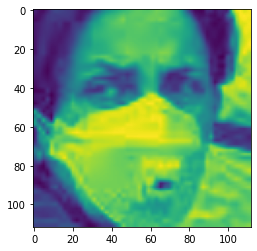

In [104]:
plt.imshow(result_image.reshape(112, 112))

In [102]:
test_image = cv2.imread("/drive/MyDrive/Face Mask Dataset/Validation/WithMask/1416.png")
test_image_grayscale = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image_resize = cv2.resize(test_image_grayscale, (112, 112))
normalized_image = test_image_resize / 255.0
result_image = np.reshape(test_image_resize, (1, 112, 112, 1))
result_image.shape
result = cnn.predict(result_image)
if int(result[0][0]) == 1:
  print("With Mask")
elif int(result[0][1]) == 1:
  print("Without Mask")

Without Mask
